In [1]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import time
import glob
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import balanced_accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from preprocessing import preprocess
from visualization import *
from cluster import *

%load_ext autoreload
%autoreload 2

data_path = '../data/'

percentile = 0.4
feature_types = ['lalle_conati', 'boroujeni_et_al', 'chen_cui', 'marras_et_al']
metadata = pd.read_csv(data_path + 'metadata.csv')

In [2]:
courses = ['analysenumerique_001',
 'analysenumerique_002',
 'analysenumerique_003',
 'cpp_fr_001',
 'dsp_001',
 'dsp_002',
 'dsp_004',
 'dsp_005',
 'dsp_006',
 'geomatique_003',
 'hwts_001',
 'hwts_002',
 'initprogcpp_001',
 'microcontroleurs_003',
 'microcontroleurs_003_003',
 'microcontroleurs_004',
 'microcontroleurs_005',
 'microcontroleurs_006',
 'progfun_002',
 'progfun_003',
 'structures_001',
 'structures_002',
 'structures_003',
 'venture_001',
 'villesafricaines_001',
 'villesafricaines_002',
 'villesafricaines_003']

### Spectral Clustering 

Using euclidean distance. You can tune the clustering by changing the gamma list.

In [ ]:
gamma_list = [0.6]

for course in courses:
    
    MODEL_PATH = '../models/saved/' + course + '/'
    
    clustering_method = 'spectral_clustering'
    labels_path = '../labels/' + course + '/' + clustering_method + '/inter-c3/'
    results_path = '../results/' + course + '/inter-c3/'

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    if not os.path.exists(labels_path):
        os.makedirs(labels_path)

    if not os.path.exists(results_path):
        os.makedirs(results_path)

    path = data_path + course + '/'
    
    df = {}
    df['course'] = []
    df['norm'] = []
    df['sparsity'] = []
    df['number_clusters'] = []
    df['silhouette_score'] = []
    df['labels'] = []
    
    # Retrieve all configurations of masking models from the directory where they are saved
    norm_sparsity = {}
    norm_sparsity['unit'] = []
    norm_sparsity['min-max'] = []
    for f in glob.glob(MODEL_PATH+'*.index'):
        f = f.replace(MODEL_PATH, '').replace('.index', '').replace('annealing_fg_', '')
        f = f.split('_')
        if f[0] == 'unit' or f[0] == 'min-max':
            norm_sparsity[f[0]].append(float(f[2]))
    
    norm_sparsity['unit'].sort()
    norm_sparsity['min-max'].sort()
    
    for norm in norm_sparsity.keys():
        list_sparsity = list(np.unique(norm_sparsity[norm]))

        for sparsity in list(np.unique(norm_sparsity[norm])):
            print('\nClustering course {0} using {1} normalization and {2} sparsity target'.format(course, 
                                                                                                   norm,
                                                                                                   sparsity))
            filename = 'annealing_fg_'+norm+'_norm_'+str(sparsity)+'_perc_'+str(percentile)
            feature_names, masks, X_masked, _, Y = get_truncated_features(MODEL_PATH, filename, course, 
                                                                          path, percentile, feature_types, 
                                                                          metadata, norm)
            
            start_time = time.time()
            
            # Distance matrix computed by feature and then aggregated 
            D = compute_distance_matrix(X_masked, 'euclidean')
            
            for gamma in gamma_list:
                S = np.exp(-gamma * D ** 2)
                try:
                    # NaNs in the similarity matrix may occur, especially in very sparse data, 
                    # causing potential issues when running eigengap heuristic
                    n_clusters = eigengap(S)
                except:
                    print('Problem found in course {0} using {1} normalization and {2} sparsity target'.format(course, 
                                                                                                               norm,
                                                                                                               sparsity))
                    continue
                
                n = 0
                for i in n_clusters:
                    if i > 2: # selects more than 2 clusters
                        n = i
                        break
                        
                labels = np.array(spectral_clustering(n).fit_predict(S))
                s_score = silhouette_score(D, labels, metric='precomputed')
                print("Found {0} clusters with {1} silhouette score".format(n, s_score))
                df['course'].append(course)
                df['norm'].append(norm)
                df['sparsity'].append(sparsity)
                df['silhouette_score'].append(s_score)
                df['number_clusters'].append(n)
                df['labels'].append(labels)
                
                np.savetxt(labels_path+'cluster_'+norm+'_norm_'+str(sparsity)+'_perc_'+str(percentile)+'_gamma_'+str(gamma)+'.txt', labels, fmt='%d')
           
            print('Time spent on clustering: {0}\n'.format(time.time() - start_time))
    df = pd.DataFrame(df)
    # Save clusters information per course
    pd.to_pickle(df, results_path+'clusters_info.pkl') 

In [7]:
percentile = 0.4
norm = 'min-max'
course = 'dsp_001'
path = data_path + course + '/'
MODEL_PATH = '../models/saved/'+ course + '/'
filename = 'annealing_fg_min-max_norm_0.43_perc_'+str(percentile)
feature_names, masks, X_masked, _, Y = get_truncated_features(MODEL_PATH, filename, course, path, percentile, feature_types, metadata, norm)

To generate the Sankey diagram, you need to train masks for each of the four percentiles (0.2, 0.4, 0.6, and 0.8) and subsequently perform clustering for all of them. Below, you can view the Sankey diagram for dsp_001:

In [14]:
create_sankey_diagram(labels_path, 'masked_perc_', [0.2, 0.4, 0.6, 0.8], Y, gamma=True, g=0.6)

The following results are using only 40% of data for the course dsp_001.

In [20]:
# Get X_masked flatten
feature_names, masks, X_masked, X, Y = get_truncated_features_flatten(MODEL_PATH, filename, course, path, percentile, feature_types, metadata, norm)


labels_path = '../labels/' + course + '/' + clustering_method +'/inter-c3/'
labels = np.loadtxt(labels_path+'cluster_min-max_norm_0.43_perc_0.4_gamma_0.6.txt', dtype=int)

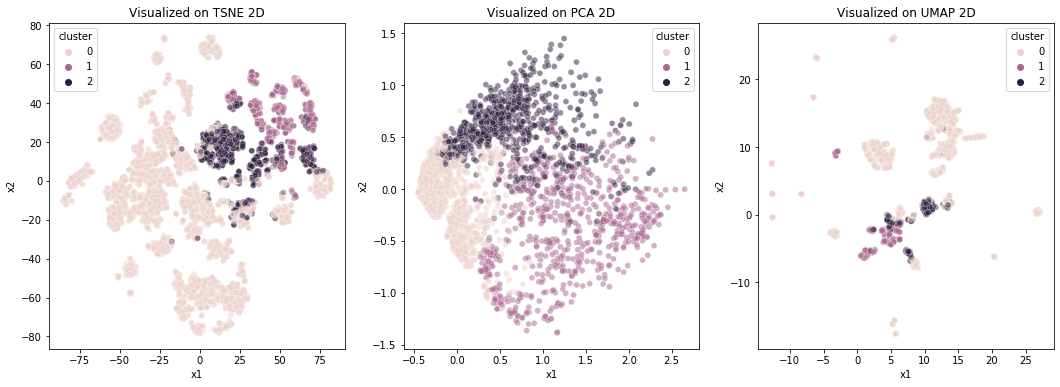

In [21]:
plot_tsne_and_pca(X_masked, labels)

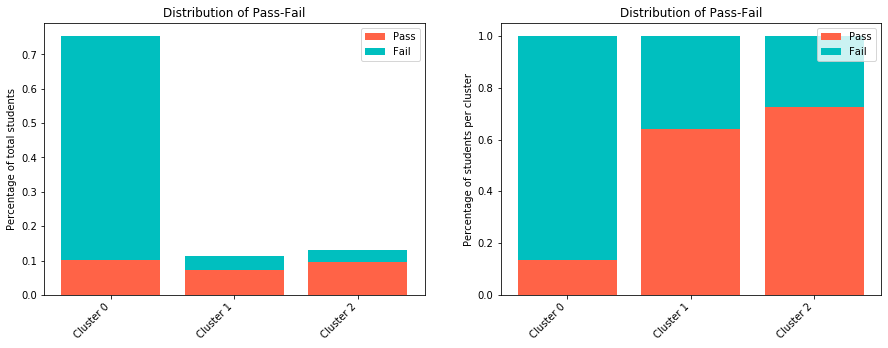

In [22]:
distributions_pass_fail(labels, Y)

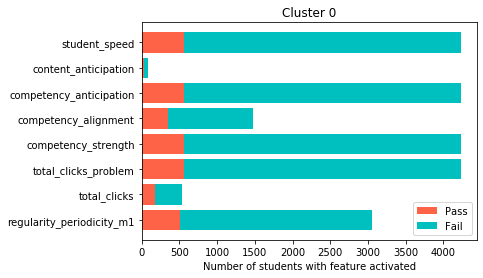

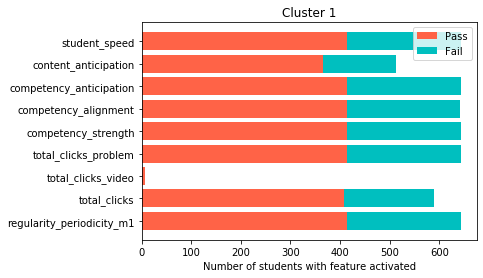

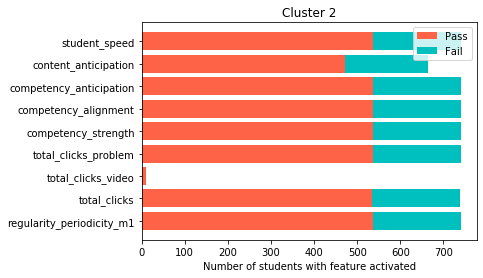

,Cluster,# instances,Avg Features
0,0,4228,5.218307
1,1,643,7.718507
2,2,740,7.909460


In [23]:
df = number_students_per_feature(labels, masks, feature_names, Y)
df

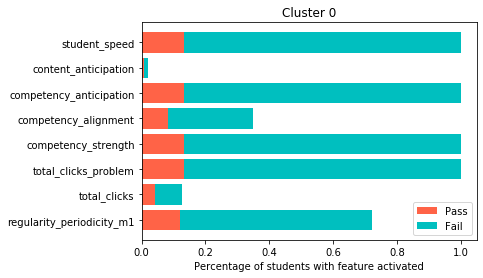

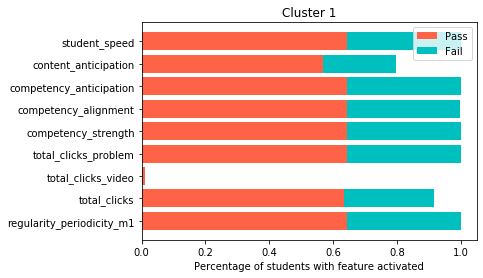

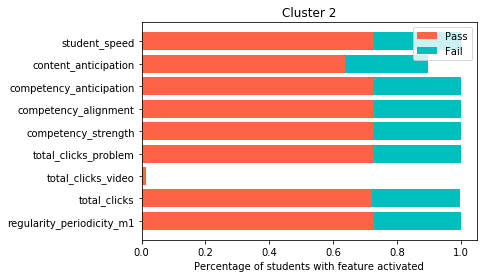

In [24]:
percentage_students_per_feature(labels, masks, feature_names, Y)

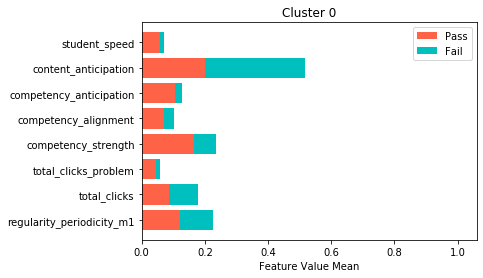

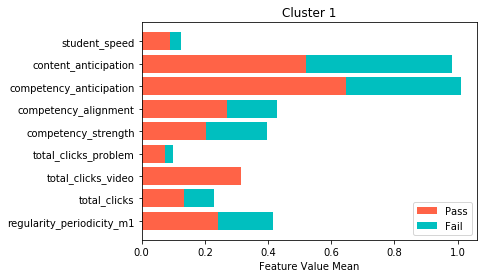

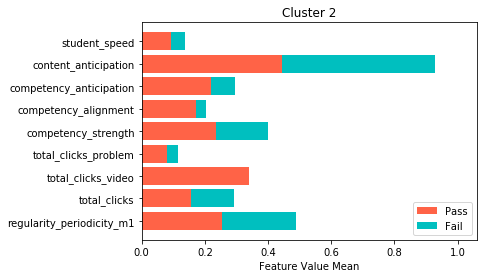

In [25]:
feature_value(labels, masks, feature_names, X, Y)

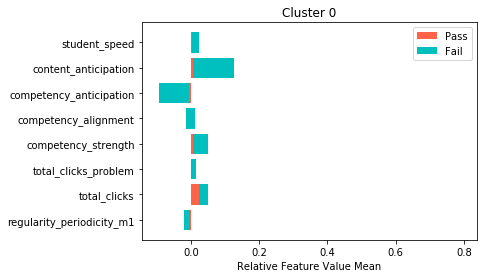

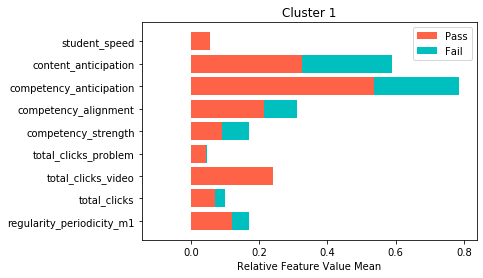

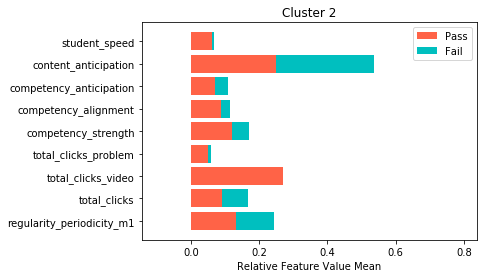

In [26]:
df = relative_feature_value(labels, masks, feature_names, X, Y)

In [27]:
df

,Feature,Avg Value,Max Value,Min Value
0,regularity_periodicity_m1,0.123201,1.0,0.0
1,total_clicks,0.063736,1.0,0.0
2,total_clicks_video,0.071058,1.0,0.0
3,total_clicks_problem,0.028297,1.0,0.0
4,competency_strength,0.113581,1.0,0.0
5,competency_alignment,0.058323,1.0,0.0
6,competency_anticipation,0.111277,1.0,0.0
7,content_anticipation,0.195443,1.0,0.0
8,student_speed,0.034115,1.0,0.0


### Compute feature importance and save

In [28]:
df_importance = pd.DataFrame()
for c in range(np.max(labels)+1):
    cluster = np.where(labels == c)[0]
    f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)
    feature_importance = {}
    for i in tf.where(f_activated)[:, 0]:
        feature_importance[feature_names[i]] = f_activated[i].numpy()/len(cluster)
    aux = pd.DataFrame(feature_importance, index=[c])
    df_importance = pd.concat([df_importance, aux])

In [29]:
df_importance

,regularity_periodicity_m1,total_clicks,total_clicks_problem,competency_strength,competency_alignment,competency_anticipation,content_anticipation,student_speed,total_clicks_video
0,0.722091,0.126301,1.0,1.0,0.35052,1.0,0.019395,1.0,NaN
1,1.000000,0.916019,1.0,1.0,0.99689,1.0,0.796267,1.0,0.009331
2,1.000000,0.998649,1.0,1.0,1.00000,1.0,0.898649,1.0,0.012162


In [30]:
results_path = '../results/' + course + '/inter-c3/'

In [31]:
df_importance.to_csv(results_path+'features_importance.csv', index=False)